# Energy — quick analysis & forecasting

This notebook explores a single-household electricity dataset (2006–2010). We look at usage patterns and build simple forecasts using SARIMA and Prophet.

## What we'll do
- Focus: `global_active_power` (kW).
- Visualize distribution, monthly and daily patterns.
- Try simple baselines and two time-series models: SARIMA and Prophet.

## Notes
We'll keep things compact: clear plots, a few models, and a short evaluation.

In [2]:
import config as config

In [5]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py 
import plotly.graph_objs as go
from scipy import stats
from prophet import Prophet 
import warnings
warnings.filterwarnings('ignore')


Data note: the raw file is large (LFS in the original repo). Set sensible dtypes and forward-fill the ~1% missing values for this demo.

In [ ]:
#Import data file
#path = 'Raw_household_power_consumption.txt'
#I downloaded data to work on my computer, but file it to big for store in Github repo, here is path to file from another user that loaded it into LFS repo
path = 'https://media.githubusercontent.com/media/mkivenson/Household-Power-Consumption/master/household_power_consumption.txt'

dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
energy = pd.read_csv(path, sep=';',dtype=dtypes, na_values="?")
energy = energy.fillna(method='ffill')

display(energy.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We add a `Date_Time` column and simple time features (Year, Month, Day, Hour). Then we keep only the columns needed for the univariate analysis and preview the data.

In [20]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,16/12/2006,2006,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,16/12/2006,2006,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,16/12/2006,2006,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,16/12/2006,2006,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,16/12/2006,2006,12,5,17,17:28:00,3.666


## Quick exploration

Look at `global_active_power`: distribution and how it changes over time. We'll plot a histogram and boxplots to see skew and outliers.

In [21]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

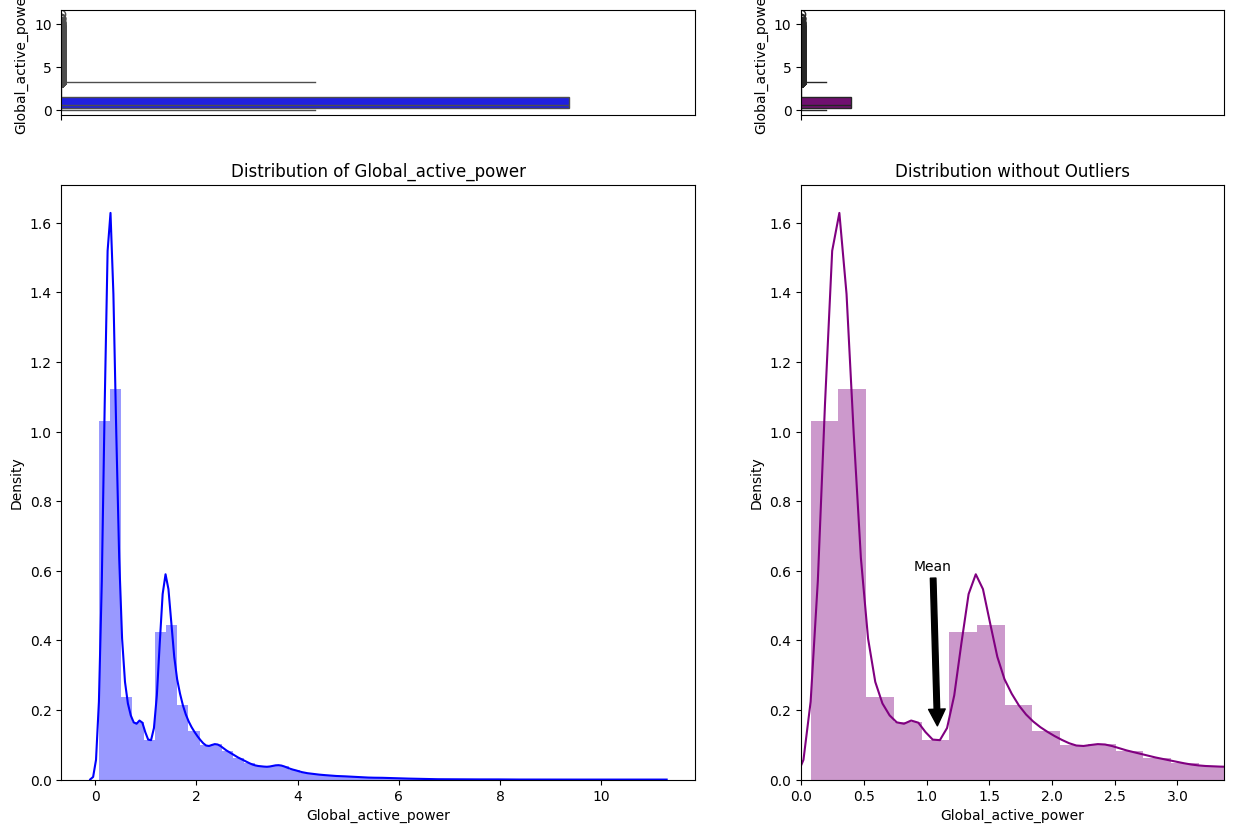

In [22]:
# Create subplots
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Main boxplot
sns.boxplot(energy["Global_active_power"] , color="blue", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Main distribution
sns.distplot(energy["Global_active_power"] , color="blue", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power')

#Zoom boxplot
sns.boxplot(energy["Global_active_power"], color="purple", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

#Zoom distribution
sns.distplot(energy["Global_active_power"], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribution without Outliers')
axes[1,1].set_xlim(0, 3.37)

# Add an arrow to mark the mean value
axes[1,1].annotate(
'Mean', xy=(energy["Global_active_power"].mean(), .15), xytext=(.9, .6),
arrowprops=dict(facecolor='black', shrink=0.01))

plt.show()

### Monthly summary

Plot mean, median and peak by month to check seasonality — the series dips in summer and rises in winter.

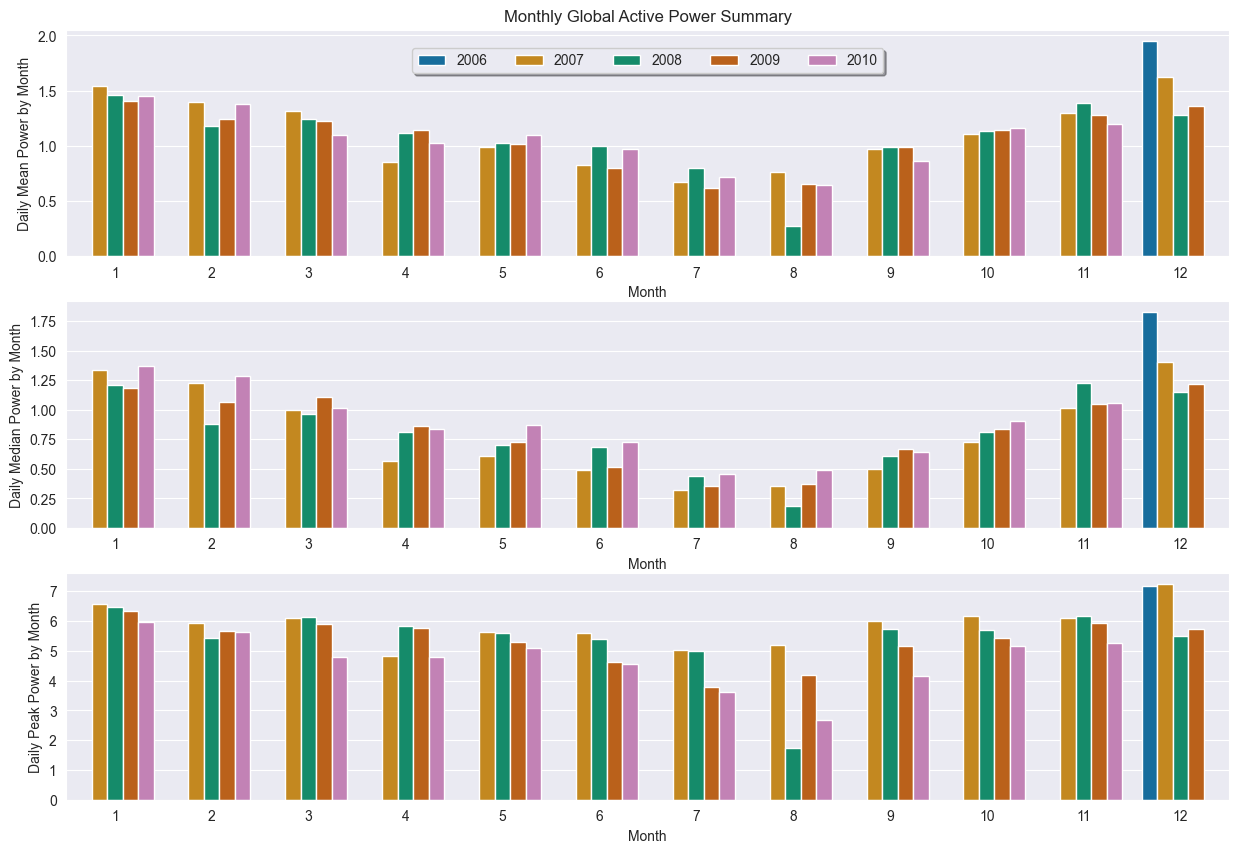

In [26]:
# Summarize power by month (mean, median, max)
# Use pandas named aggregation to avoid deprecated nested dict syntax
energy_monthly_summary = (
    energy.groupby(by=['Year', 'Month', 'Date'], as_index=False)
    .agg(
        mean_active_power=('Global_active_power', 'mean'),
        median_active_power=('Global_active_power', 'median'),
        max_active_power=('Global_active_power', 'max')
    )
)

# Create subplots
sns.set_style("darkgrid")
f, axes = plt.subplots(3, figsize=(15, 10), sharex=False)

# Monthly Mean subplot
mean = sns.barplot(
    x=energy_monthly_summary.Month,
    y=energy_monthly_summary.mean_active_power,
    hue=energy_monthly_summary.Year,
    palette="colorblind",
    ax=axes[0],
    ci=None,
)
mean.set_title('Monthly Global Active Power Summary')
mean.set_ylabel('Daily Mean Power by Month')
mean.legend_.remove()

# Monthly Median subplot
median = sns.barplot(
    x=energy_monthly_summary.Month,
    y=energy_monthly_summary.median_active_power,
    hue=energy_monthly_summary.Year,
    palette="colorblind",
    ax=axes[1],
    ci=None,
)
median.legend_.remove()
median.set_ylabel('Daily Median Power by Month')

# Monthly Peak subplot
max_plot = sns.barplot(
    x=energy_monthly_summary.Month,
    y=energy_monthly_summary.max_active_power,
    hue=energy_monthly_summary.Year,
    palette="colorblind",
    ax=axes[2],
    ci=None,
)
max_plot.set_ylabel('Daily Peak Power by Month')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.35), shadow=True, ncol=5)
plt.show()

### Weekday summary

Boxplots by weekday (faceted by year) show how medians and spread change across years — useful to spot weekday/weekend differences.

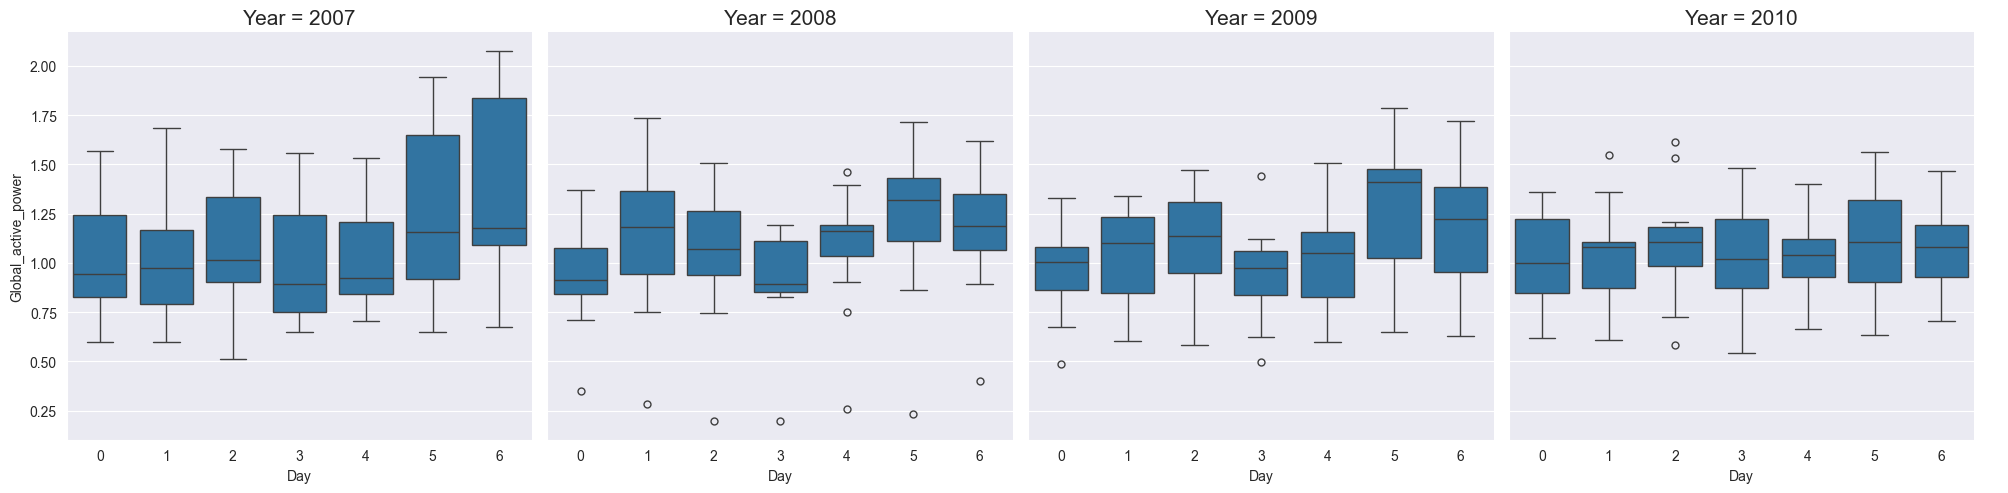

In [27]:
energy_weekday_summary = energy.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="box",
           col="Year")
day_plot.set_titles(size = 15)


### Hourly summary

Hourly averages show two daily peaks (around 07:00 and 21:00) that persist across years.

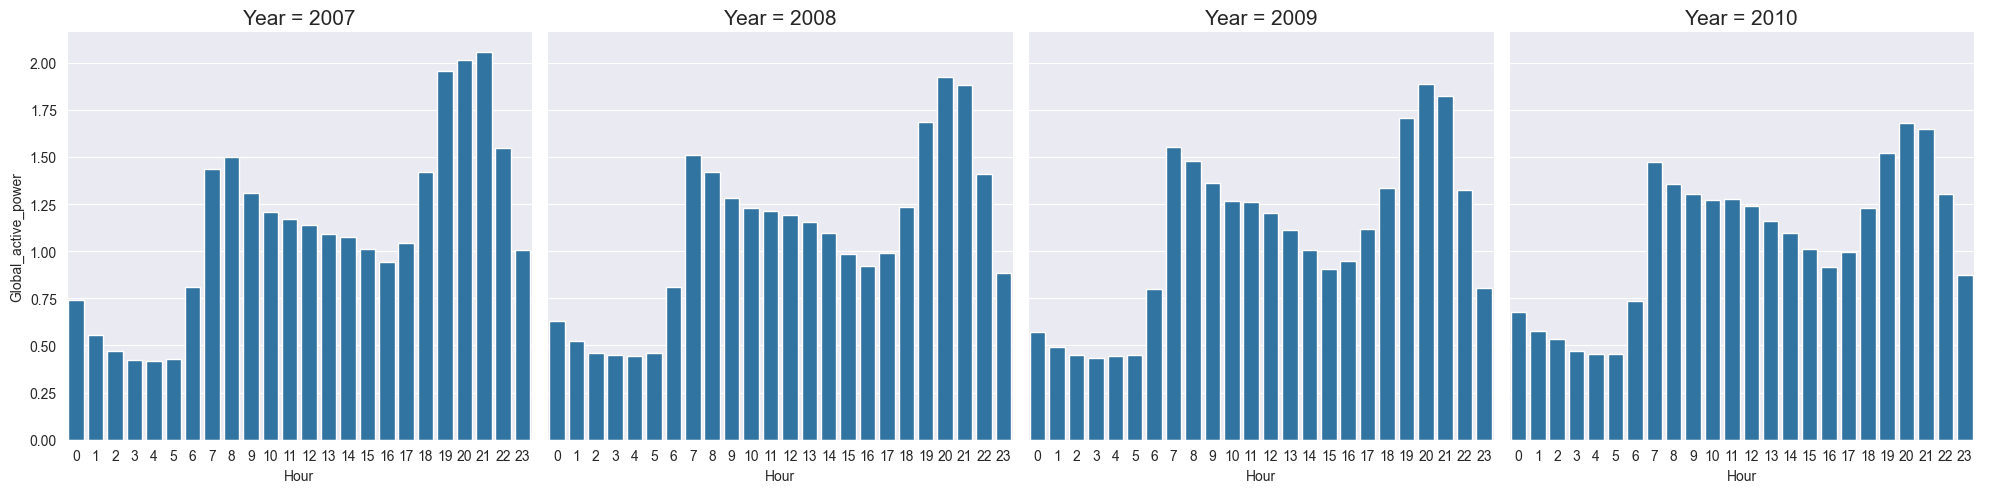

In [28]:
energy_hourly_summary = energy.groupby(by=['Year','Month','Day','Hour'], 
                                       as_index=False)[['Global_active_power']].mean()

hour_plot = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Year",
           ci=None)
hour_plot.set_titles(size = 15)

### Hourly averages by month

Daily peaks are stable, but monthly patterns show small shifts in level and shape.

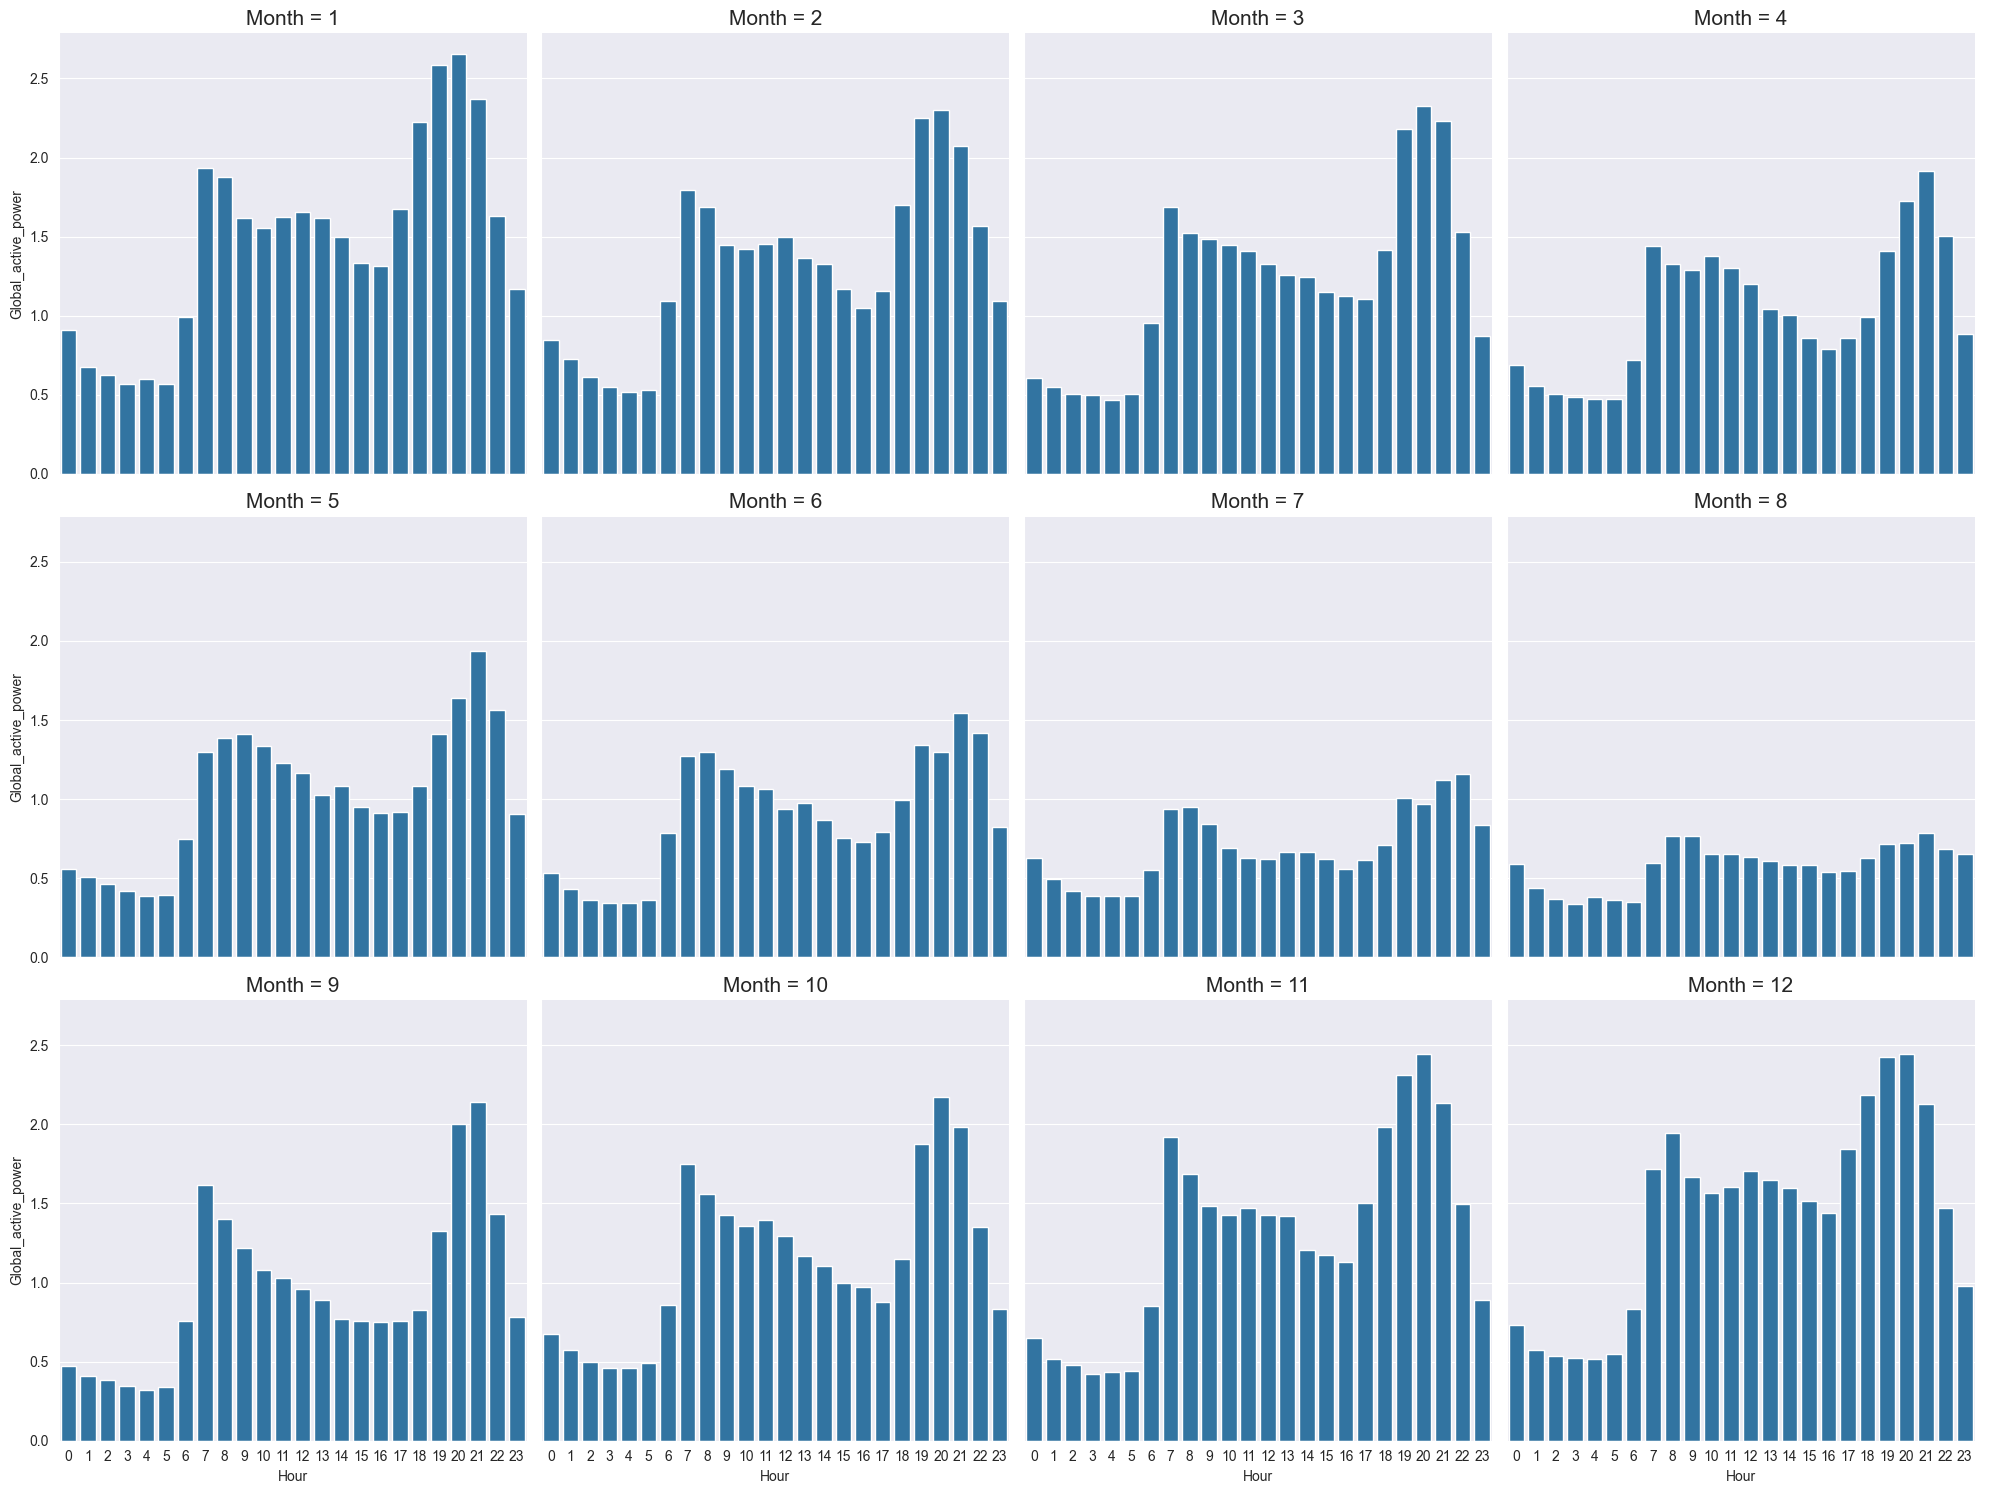

In [29]:
current_palette = sns.color_palette("Paired")

hour_plot2 = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Month",
           col_wrap = 4,
           ci=None)
hour_plot2.set_titles(size = 15)

### Interactive overview

An interactive plot shows daily mean, median and peak values with controls to focus on different time windows or metrics.

In [31]:
energy.Date = pd.to_datetime(energy['Date'])
energy_daily_summary = energy.groupby('Date', 
                                      as_index=False).agg(
    {'Global_active_power':{'mean_active_power': 'mean',
                            'median_active_power': 'median',
                            'max_active_power': 'max'}})
mean_power = go.Scatter(x=energy_daily_summary.Date,
                        y=energy_daily_summary.Global_active_power.mean_active_power,
                        name='mean_power',
                        line=dict(color='red'))

median_power = go.Scatter(x=energy_daily_summary.Date,
                            y=energy_daily_summary.Global_active_power.median_active_power,
                            name='median_power',
                            line=dict(color='blue'))

max_power = go.Scatter(x=energy_daily_summary.Date,
                       y=energy_daily_summary.Global_active_power.max_active_power,
                       name='max_power',
                       line=dict(color='green'))

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Mean',
                 method = 'update',
                 args = [{'visible': [True, False, False]},
                         {'title': 'Mean Global Active Power'}]),
                         
            dict(label = 'Median',
                 method = 'update',
                 args = [{'visible': [False, True, False]},
                         {'title': 'Median Global Active Power'}]),
                         
            dict(label = 'Maximum',
                 method = 'update',
                 args = [{'visible': [False, False, True]},
                         {'title': 'Maximum Global Active Power'}]),
            dict(label = 'All',
                 method = 'update',
                 args = [{'visible': [True, True, True]},
                         {'title': 'Overview of Global Active Power'}]),              
        ]),
    )
])

data = [mean_power, median_power, max_power]

layout = dict(title='Daily Global Active Power', 
              showlegend=True, 
              updatemenus = updatemenus,
              legend=dict(orientation="h"),
              xaxis = dict(
                  rangeselector=dict(
                      buttons=list([
                          dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                          dict(count=6,
                             label='6m',
                             step='month',
                             stepmode='backward'),
                          dict(count=1,
                            label='1y',
                            step='year',
                            stepmode='todate'),
                          dict(count=2,
                            label='2y',
                            step='year',
                            stepmode='backward'),
                          dict(step='all')
                      ]))))

plot = dict(data=data, layout=layout)
py.plotly.iplot(plot, filename='household_power_consumption')

SpecificationError: nested renamer is not supported

## Pre-process data

We already cleaned the raw data. Below we create hourly averages and label-encode the `Year` column for simple modeling.

In [ ]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])
energy_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


## Time-series forecasting

We'll try a quick baseline (linear regression) and then move to SARIMA and Prophet. First, we split the data (75% train / 25% test) for the baseline.

In [ ]:
from sklearn.model_selection import train_test_split
x = energy_hourly_summary[['Year','Month','Day','Hour']]
y = energy_hourly_summary.Global_active_power
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

#### Apply Forecasting Methods

The linear regression method below uses the linear relationship between the x and y components of the training set to predict the y component of the test set.

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)

#### Evaluate Performance
The scatter plot below shows the relationship between the actual test values and the predicted test values. It is evident from the equation of the regression line and the r-squared value that this is not a good model for the Global_active_power time series.

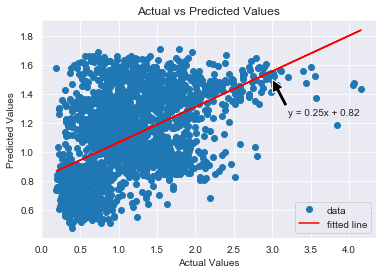

r-squared: 0.259503


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.annotate(
'y = ' + str(round(slope,2)) + 'x' + ' + ' + str(round(intercept,2)), xy=(3, 1.5), xytext=(3.2, 1.25),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.xlabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Predicted Values')
plt.show()
print("r-squared: %f" % r_value**2)

### SARIMAX

SARIMAX handles seasonality and is a solid classical baseline. We train on 2006–2009 and test on 2010.

In [ ]:
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

#### Apply Forecasting Methods

For this model, we apply SARIMA on a weekly summary of the Global_active_power. I attempted to use days, however the processing time was too long.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
train_monthly=train[['Global_active_power']].resample('W').mean()
mod = SARIMAX(train_monthly, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 50), #50 = number of weeks that we are forcasting
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [ ]:
results.forecast()

2010-01-10    1.02102
Freq: W-SUN, dtype: float64

Note: SARIMA `.predict()` uses indices that depend on the seasonal order. Pick start/end carefully to align with your forecasting horizon.

In [ ]:
predictions = results.predict(start='2010-01-03', end='2010-12-19')

#### Evaluate

Compare the distribution of SARIMA weekly predictions vs actuals in 2010. This helps spot bias or distributional mismatches.

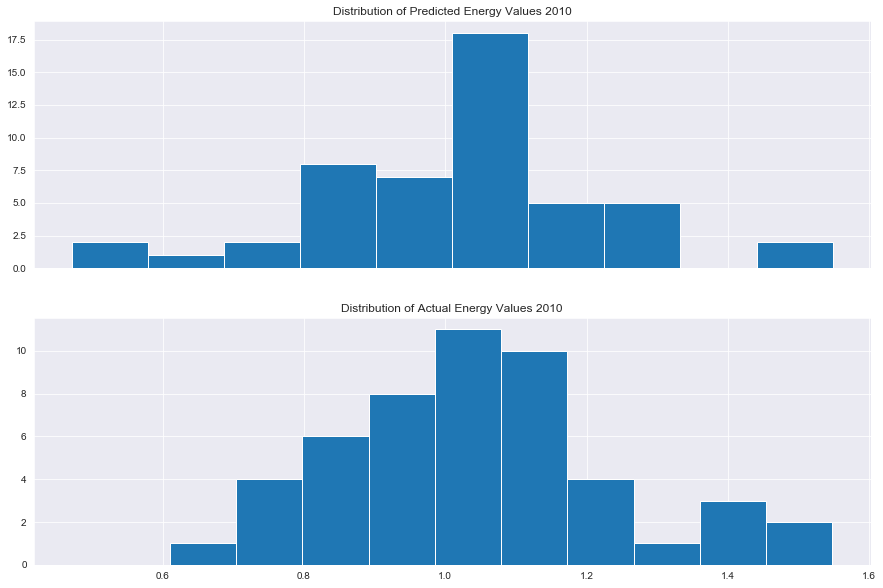

In [ ]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(predictions.values, bins=10)
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test[['Global_active_power']].resample('W').mean().values), bins=10)
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

### Actual vs predicted (SARIMA)

We combine weekly actuals and SARIMA predictions to compare time series and inspect residuals. Good for checking where the model misses.

In [ ]:
#merge on Date_Time
test[['Global_active_power']].resample('W').mean().reset_index()
prediction = pd.DataFrame(predictions).reset_index()
prediction.columns = ['Date_Time','Global_active_power']

res = pd.merge(test[['Global_active_power']].resample('W').mean(), 
               prediction, 
               how='left', 
               on='Date_Time')

res.columns = ['Date_Time','actual','predictions']
res.insert(3, 'residuals', res['actual'] - res['predictions']) #residuals
res.head()

MSE =  0.05315903905285634


,Date_Time,actual,predictions,residuals
0,2010-01-03,0.976101,1.512261,-0.536160
1,2010-01-10,0.920572,1.021020,-0.100448
2,2010-01-17,1.451530,1.305795,0.145734
3,2010-01-24,1.535291,1.039394,0.495898
4,2010-01-31,1.548028,0.853604,0.694425


Upon looking at the plot of actual versus predicted weekly Global_active_power, we see that the SARIMA predictions were close to the actual values. The plot of residuals shows that the difference between actuals and predicted values may have a pattern: mostly positive residuals in the first half of 2010, and mostly negative residuals in the latter half of 2010. Using the residuals, we calculate a Mean Squared Error (MSE) of 0.0532.

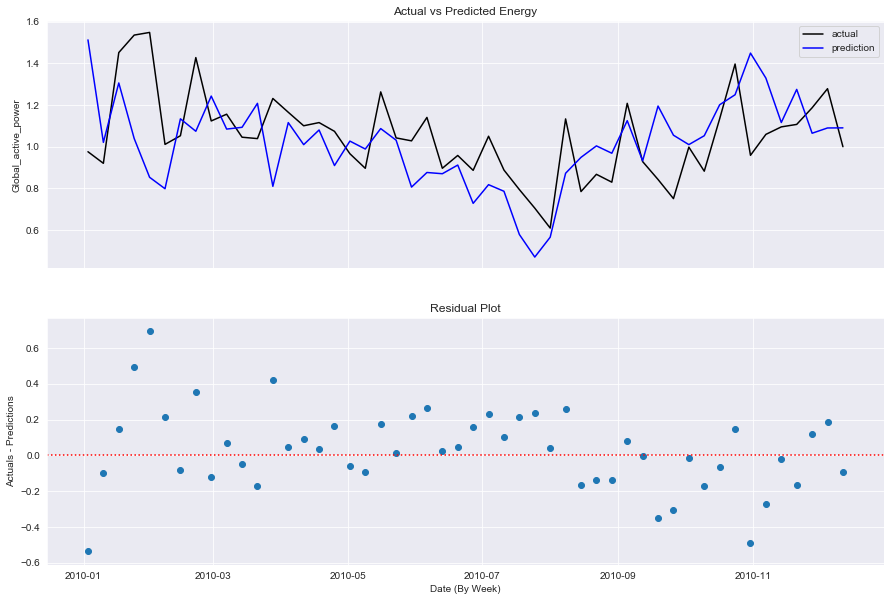

MSE =  0.05315903905285634


In [ ]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(res['Date_Time'],res['actual'], color='black', label='actual')
axes[0].plot(res['Date_Time'],res['predictions'], color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(res['Date_Time'],(res['actual'] - res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Date (By Week)')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res['residuals']**2)) #MSE

### Prophet

Prophet models seasonality flexibly. Here we train on daily averages (2006–2009) and test on 2010.

In [39]:
train_2 = train.resample('D').mean().reset_index()
train_2 = train_2[['Date_Time', 'Global_active_power']]
train_2.columns = ['ds', 'y']
train_2.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [38]:
test_2 = test.resample('D').mean().reset_index()
test_2 = test_2[['Date_Time', 'Global_active_power']]
test_2.columns = ['ds', 'y']
test_2.head()

,ds,y
0,2010-01-01,0.850175
1,2010-01-02,0.910976
2,2010-01-03,1.446843
3,2010-01-04,1.113981
4,2010-01-05,1.541514


#### Apply forecasting methods

We'll add a custom daily seasonality to Prophet (fourier_order=8) so the model captures the main cycles without overfitting.

In [40]:
# Ensure train/test exist — if not, (re)create from `energy` dataframe
if 'train' not in globals() or 'test' not in globals():
    if 'energy' not in globals():
        raise RuntimeError('`energy` dataframe is not defined. Run the earlier data-loading cells first.')
    # Recreate indexed_engery, train, test
    indexed_engery = energy[['Date_Time','Global_active_power','Year','Month']].set_index('Date_Time')
    train = indexed_engery[indexed_engery['Year'] < 2010]
    test = indexed_engery[indexed_engery['Year'] == 2010]

# Create daily resampled train_2 if missing
if 'train_2' not in globals():
    train_2 = train.resample('D').mean().reset_index()
    if 'Global_active_power' not in train_2.columns:
        raise RuntimeError('Expected column `Global_active_power` not found after resampling. Check earlier preprocessing.')
    train_2 = train_2[['Date_Time', 'Global_active_power']]
    train_2.columns = ['ds', 'y']

# Validate and clean train_2
train_2['ds'] = pd.to_datetime(train_2['ds'], errors='coerce')
train_2['y'] = pd.to_numeric(train_2['y'], errors='coerce')
train_2 = train_2.dropna(subset=['ds','y']).reset_index(drop=True)

if train_2.empty:
    raise ValueError('train_2 is empty after cleaning. Ensure the dataset contains data and that previous preprocessing completed successfully.')
if len(train_2) < 10:
    raise ValueError(f'train_2 has only {len(train_2)} rows after resampling — too few for Prophet. Need at least ~10 daily points.')

# Check Prophet import
try:
    from prophet import Prophet
except Exception as e:
    raise RuntimeError('Prophet is not available in the environment. Install it with `pip install prophet` and retry.')

# Fit Prophet model with explicit seasonalities
ph = Prophet(weekly_seasonality=False)
ph.add_seasonality(name='daily', period=1, fourier_order=8)

try:
    ph.fit(train_2)
except Exception as e:
    raise RuntimeError(f'Prophet fit failed: {e}\nMake sure `train_2` has columns `ds` (datetime) and `y` (numeric) and sufficient rows.')

print('Prophet model fitted on', len(train_2), 'rows')


11:02:39 - cmdstanpy - INFO - Chain [1] start processing
11:02:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted on 1112 rows


Make a 365-day forecast. `yhat_lower`/`yhat_upper` show the model's uncertainty (default ~80% CI).

In [41]:
future = ph.make_future_dataframe(periods=365)
forecast = ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2006-12-16,1.599354,1.159792,2.023278
1,2006-12-17,1.608553,1.220321,2.027853
2,2006-12-18,1.618104,1.207989,2.025247
3,2006-12-19,1.627692,1.221464,2.035917
4,2006-12-20,1.636992,1.184205,2.052251


#### Quick evaluation

Plot predictions vs actuals. Points = actuals; line = forecast. Test data points are highlighted so you can see out-of-sample fit.

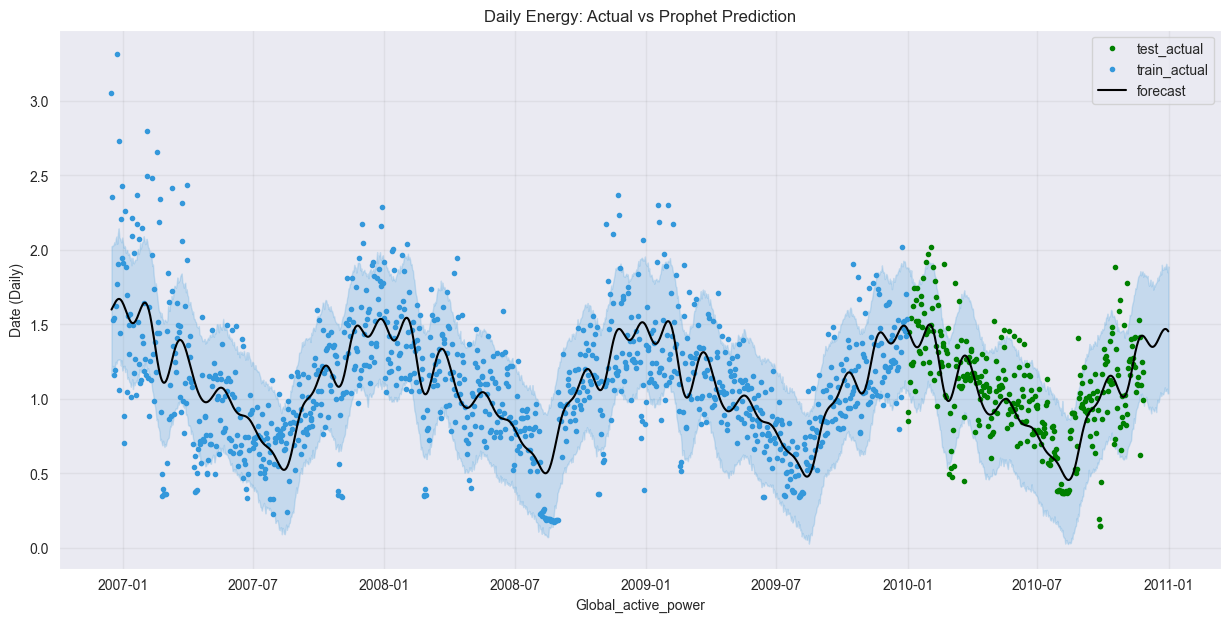

In [42]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_2.ds, test_2.y, '.', color='green', label = "test_actual")
plt.plot(train_2.ds, train_2.y, '.', color='#3498db', label = "train_actual")
plt.plot(forecast.ds, forecast.yhat, color='black', label = "forecast")
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

### Residuals

Merge actuals and forecasts to compute residuals and check where the model over- or under-predicts.

In [43]:
#merge on Date_Time
res2 = pd.merge(test_2, 
               forecast[['ds','yhat']], 
               how='left', 
               on='ds')
res2.columns = ['Date_Time','actual','predictions']
res2.insert(3, 'residuals', res2['actual'] - res2['predictions']) #residuals
res2.head()

,Date_Time,actual,predictions,residuals
0,2010-01-01,0.850175,1.464563,-0.614388
1,2010-01-02,0.910976,1.454484,-0.543508
2,2010-01-03,1.446843,1.443365,0.003478
3,2010-01-04,1.113981,1.431512,-0.317532
4,2010-01-05,1.541514,1.419260,0.122254


Residuals look fairly stable in 2010. We also report a simple MSE for rough comparison across models.

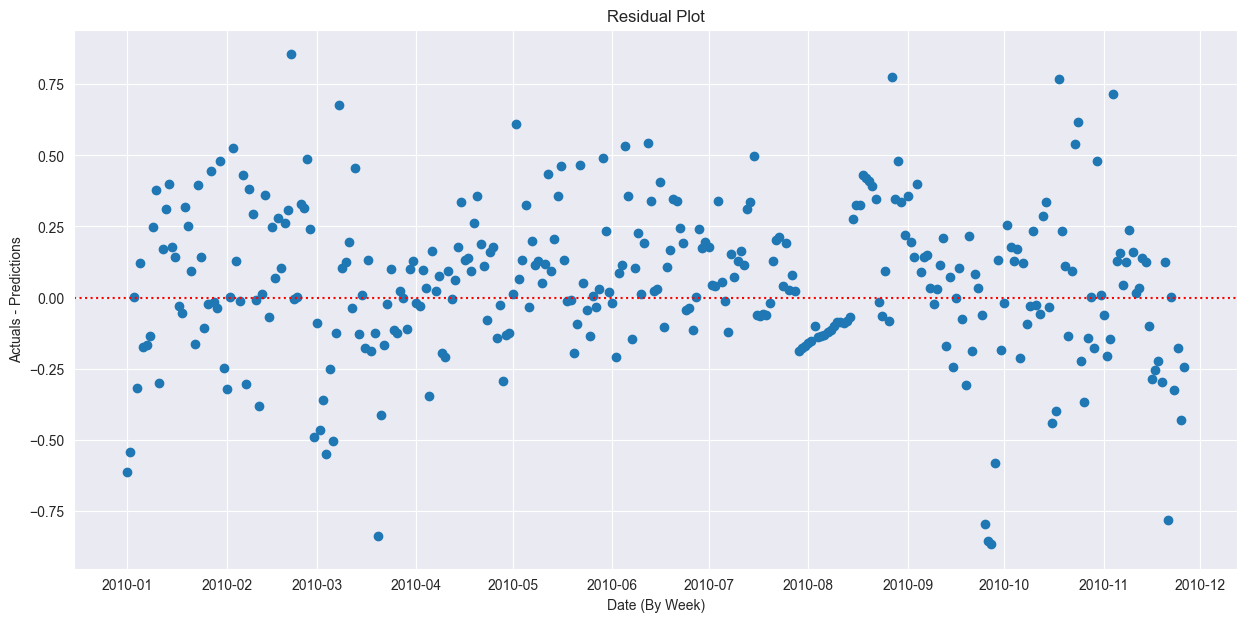

MSE =  0.0725268382411768


In [44]:
fig = plt.gcf()
fig.set_size_inches(15, 7)

#plot of residuals
plt.scatter(res2['Date_Time'],(res2['residuals']))
plt.title('Residual Plot')
plt.xlabel('Date (By Week)')
plt.ylabel('Actuals - Predictions')
plt.axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res2['residuals']**2)) #MSE

## Wrap-up

Both SARIMA and Prophet capture seasonality here. SARIMA is a good classical baseline; Prophet is quick to tune and works well with daily data. Next steps: add weather regressors, tune parameters, or try cross-validation.

## References
- Linear regression notes: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
- SARIMA primer: https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- Prophet docs: https://facebook.github.io/prophet/